# Facón

Facón is an experimental python library for subdividing a GeoDataFrame of administrative boundaries into a new GeoDataFrame of approximately equal area zones with evenly distributed centres constrained by the boundaries of the original geometries. A target area in metres squared is used to determine how many subdivisions should be created. It was developed in collaboration with Sebastián Anapolsky.

## Approaches to zonification

Adminstrative boundaries are typically driven by a need to maintain an approximately equal population in each area while maintaining spatial contiguity (i.e. no gaps between the zones). These constraints typically lead to administrative areas that vary greatly in area (m2).

Transport analysis in contrast tends to take a regular (square or ideally hexagonal) grid as its starting point, creating a set of zones of equal area with an equal distance from the centre of one zone to the centre of the next.

These two approaches to zonification conflict when, for example, carrying out studies into the relationship between social indicators from census data and the time/cost of travel.

## A hybrid solution

Facón proposes a hybrid solution, creating approximately equal area zones with approximately evenly spaced centres that nevertheless respect the original adminstrative boundaries. It uses K-Means clustering to approximate the zones and their centroids and voronoi regions to create the subdivisions. It benefits from the fact that K-Means creates a predefined number of clusters (here determined by dividing the area (m2) of the administrative zone by the desired target area (m2) of the new zones) that are approximately circular/sperical.

## References

It was inspired by two prior pieces of work:

### [Geovoronoi by Markus Konrad at WZB (Berlin Social Science Center)](https://github.com/WZBSocialScienceCenter/geovoronoi)

Geovoronoi is a python library for generating voronoi regions inside an administrative boundary given a set of predetermined starting points. The regions that it generates are driven by a set of given centres and are not necessarily of similar area.

### [Paul Ramsey - PostGIS Polygon Splitting](http://blog.cleverelephant.ca/2018/06/polygon-splitting.html)

This post by Paul Ramsey on achieving the desired result with PostGIS was instrumental in pointing the way to using K-Means clustering to subdivide the polygons into approximately equal areas.

## Imports

In [31]:
import zipfile
from urllib.request import urlretrieve

import geopandas as gpd

import matplotlib.pyplot as plt

import facon

/home/nick/anaconda3/envs/osmnx-dev/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


## Get the data

In [4]:
urlretrieve("http://cdn.buenosaires.gob.ar/datosabiertos/datasets/comunas/CABA_comunas.geojson", "CABA_comunas.geojson")
urlretrieve("https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip",
            "statistical-gis-boundaries-london.zip")
# unzip the London statistical boundaries file
with zipfile.ZipFile("statistical-gis-boundaries-london.zip", 'r') as zipped_obj:
    zipped_obj.extractall(".")

('statistical-gis-boundaries-london.zip',
 <http.client.HTTPMessage at 0x7f89e00f6978>)

## Read into GeoPandas

PROJCS["OSGB 1936 / British National Grid",GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


<AxesSubplot:>

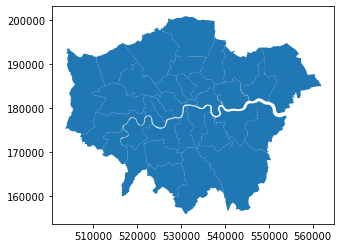

In [95]:
London_boroughs = gpd.read_file("statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
print(London_boroughs.crs)
London_boroughs.plot()

<AxesSubplot:>

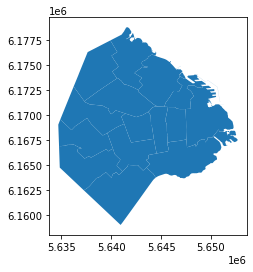

In [96]:
Buenos_Aires_comunas = gpd.read_file("CABA_comunas.geojson")
Buenos_Aires_comunas.to_crs(epsg=5347, inplace=True)
Buenos_Aires_comunas.plot()

## Get the centres and extents of both cities to plot at equal scale

In [37]:
caba_west, caba_south, caba_east, caba_north = Buenos_Aires_comunas.total_bounds

caba_width = caba_east - caba_west
caba_height = caba_north - caba_south

caba_centre_x = caba_west + caba_width/2
caba_centre_y = caba_south + caba_height/2

In [38]:
gla_west, gla_south, gla_east, gla_north = London_boroughs.total_bounds

gla_width = gla_east - gla_west
gla_height = gla_north - gla_south

gla_centre_x = gla_west + gla_width/2
gla_centre_y = gla_south + gla_height/2

## Plot administrative areas as downloaded

In [106]:
caba_centre_x - gla_width/2


5614485.66381571

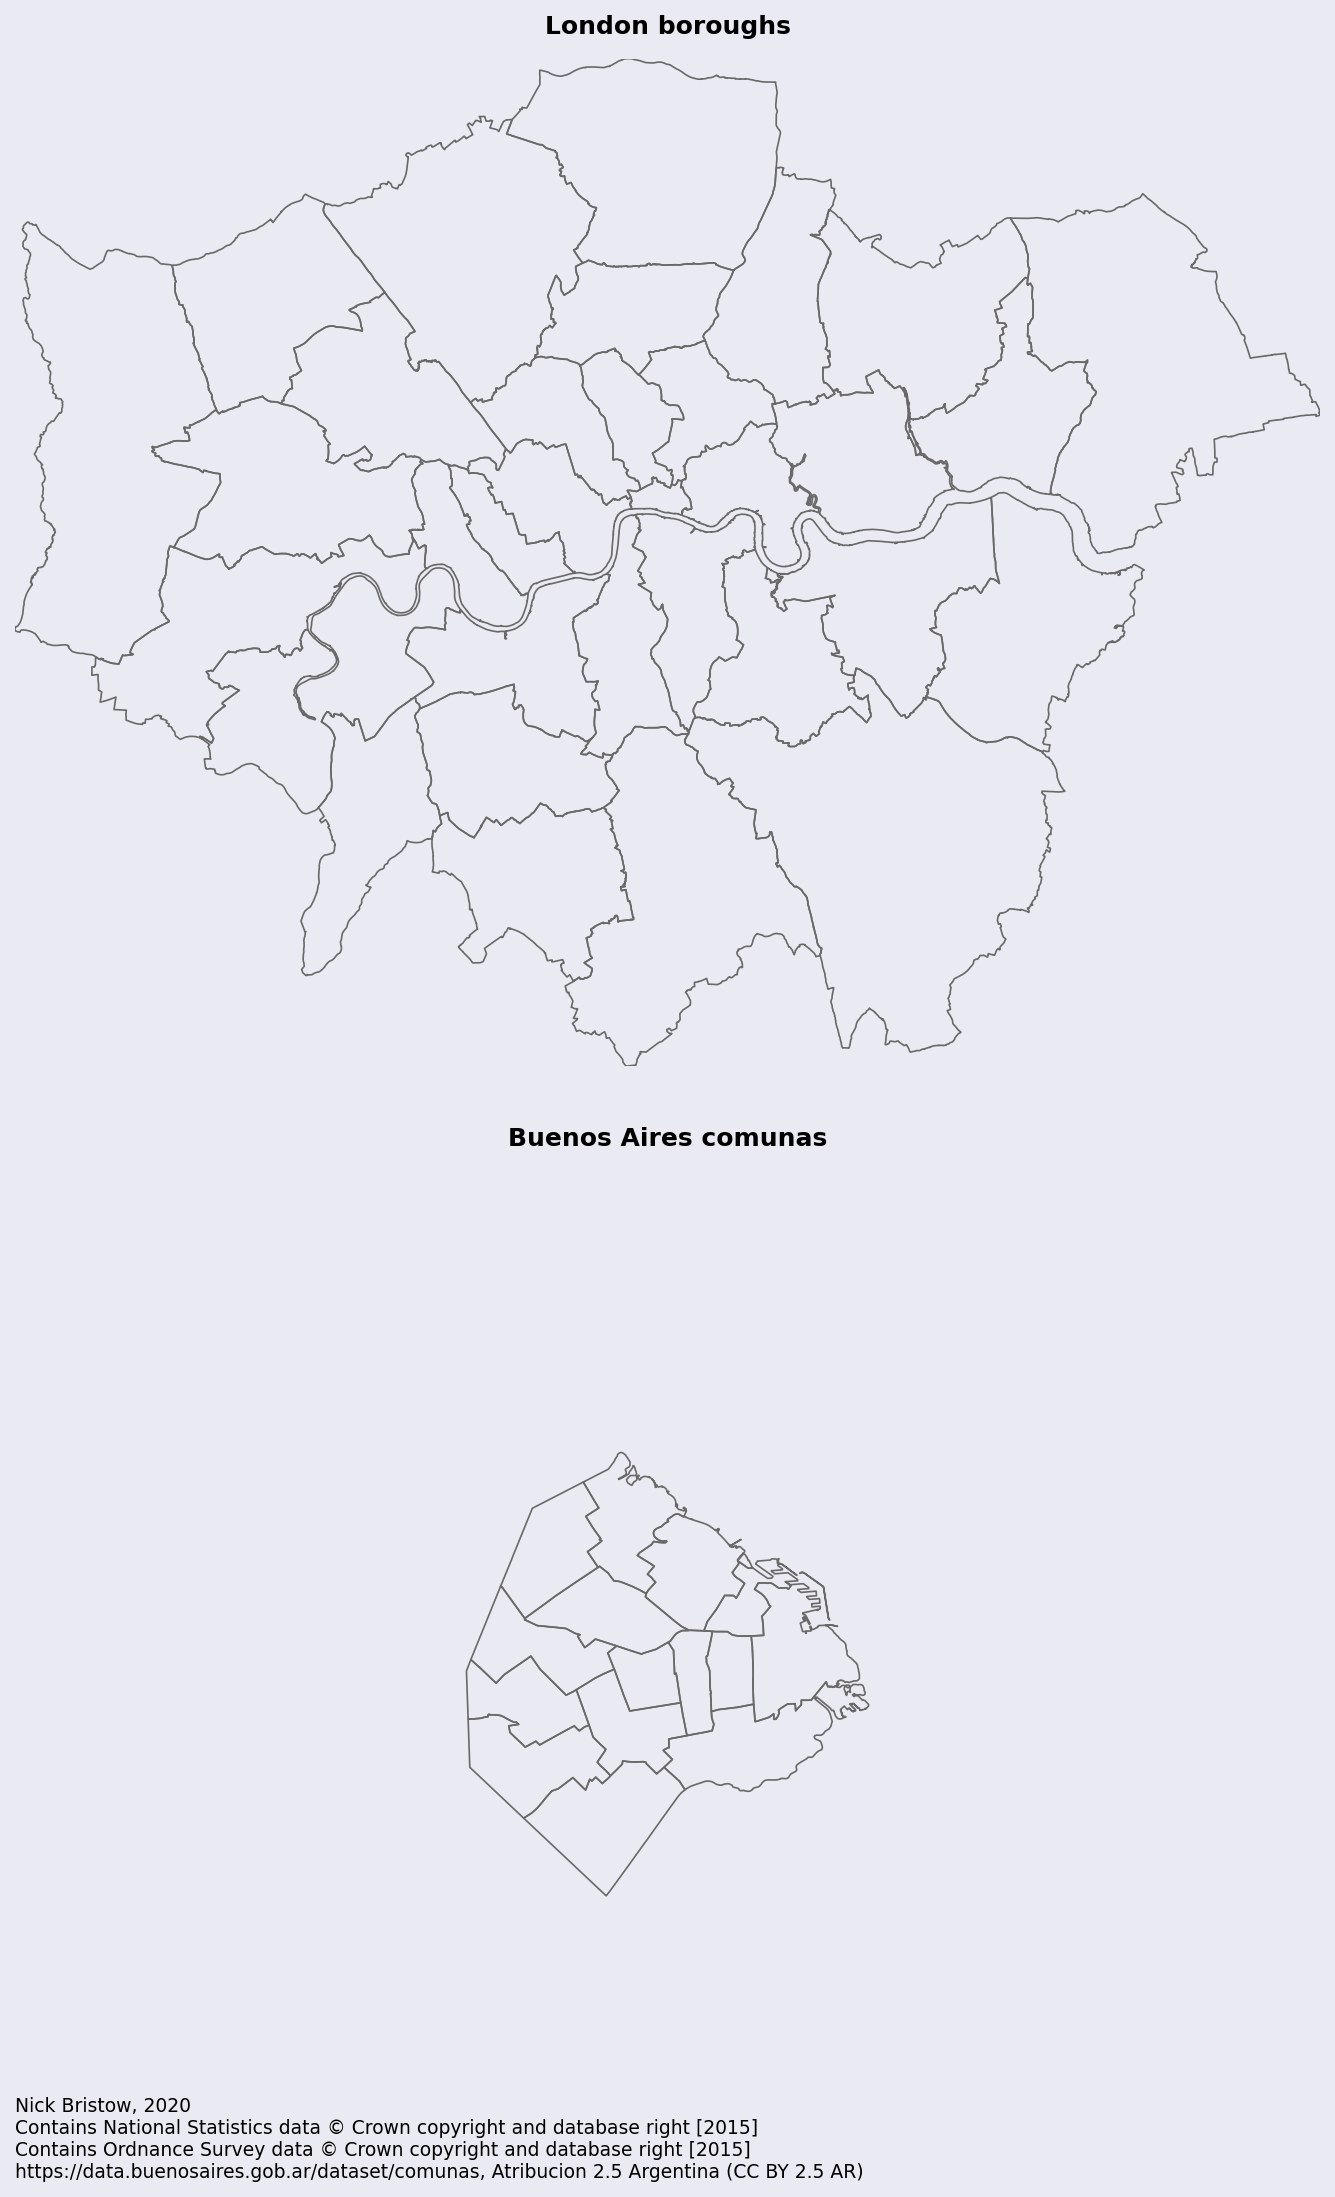

In [114]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,15), dpi=150)
fig.patch.set_facecolor('#EAEAF2')

London_boroughs.plot(ax=ax1, facecolor='none', edgecolor='dimgrey', linewidth=0.8)
ax1.set_xlim(left = gla_centre_x - gla_width/2,
             right = gla_centre_x + gla_width/2)
ax1.set_ylim(bottom = gla_centre_y - gla_height/2,
             top = gla_centre_y + gla_height/2)
ax1.set_title('London boroughs',
              pad=12,
              fontdict={'fontsize': 12,
                        'fontweight': 'bold',
                       })
ax1.axis('off')

Buenos_Aires_comunas.plot(ax=ax2, facecolor='none', edgecolor='dimgrey', linewidth=0.8)
ax2.set_xlim(left = caba_centre_x - gla_width/2,
             right = caba_centre_x + gla_width/2)
ax2.set_ylim(bottom = caba_centre_y - gla_height/2,
             top = caba_centre_y + gla_height/2)
ax2.set_title('Buenos Aires comunas',
              pad=12,
              fontdict={'fontsize': 12,
                        'fontweight': 'bold',
                       })
ax2.axis('off')

# Attribution
ax2.text(5614485, 6146364, "Nick Bristow, 2020\n"
         "Contains National Statistics data © Crown copyright and database right [2015]\n"
         "Contains Ordnance Survey data © Crown copyright and database right [2015]\n"
         "https://data.buenosaires.gob.ar/dataset/comunas, Atribucion 2.5 Argentina (CC BY 2.5 AR)",
         fontdict = {'fontsize':9})

# Save the file
fig.tight_layout()
fig.savefig('London_boroughs_Buenos_Aires_comunas.png', facecolor='#EAEAF2')

## Subdivide the adminsitrative areas with Facón

- aim for subdivisions of around 250 hectares

In [51]:
subdivided_London_boroughs = facon.subdivide_zones(London_boroughs, zone_id_col="GSS_CODE", target_area_m2 = 2_500_000)

CRS of the input GDF: PROJCS["OSGB 1936 / British National Grid",GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] . Assuming this is in metres.


In [49]:
subdivided_Buenos_Aires_comunas = facon.subdivide_zones(Buenos_Aires_comunas, zone_id_col="ID", target_area_m2 = 2_500_000)

CRS of the input GDF: epsg:5347 . Assuming this is in metres.
Fragment not merged POLYGON ((5649932.981945471 6171297.961011844, 5649959.889292415 6171353.22729539, 5649981.306398139 6171312.344259394, 5649985.407322809 6171305.064241073, 5649994.119949164 6171289.596667925, 5650052.219049088 6171178.531142089, 5650052.888030413 6171177.252150273, 5650053.988470491 6171174.350849748, 5650054.603181985 6171171.309192611, 5650054.715791953 6171168.208160057, 5650054.323352462 6171165.130029295, 5650053.43631012 6171162.156373248, 5650052.990278644 6171161.240107438, 5650052.078178584 6171159.366264811, 5650050.285000393 6171156.833784083, 5650048.104416329 6171154.626031748, 5650029.514584304 6171143.6335748, 5650026.910017071 6171142.993796145, 5650024.23804391 6171142.762404492, 5650021.56217252 6171142.944834616, 5650018.946261336 6171143.536712113, 5650016.452620727 6171144.523982341, 5650014.140515811 6171145.883133361, 5650012.06497541 6171147.581814276, 5650004.155047037 6171161.9

## Plot administrative areas and subdivisions

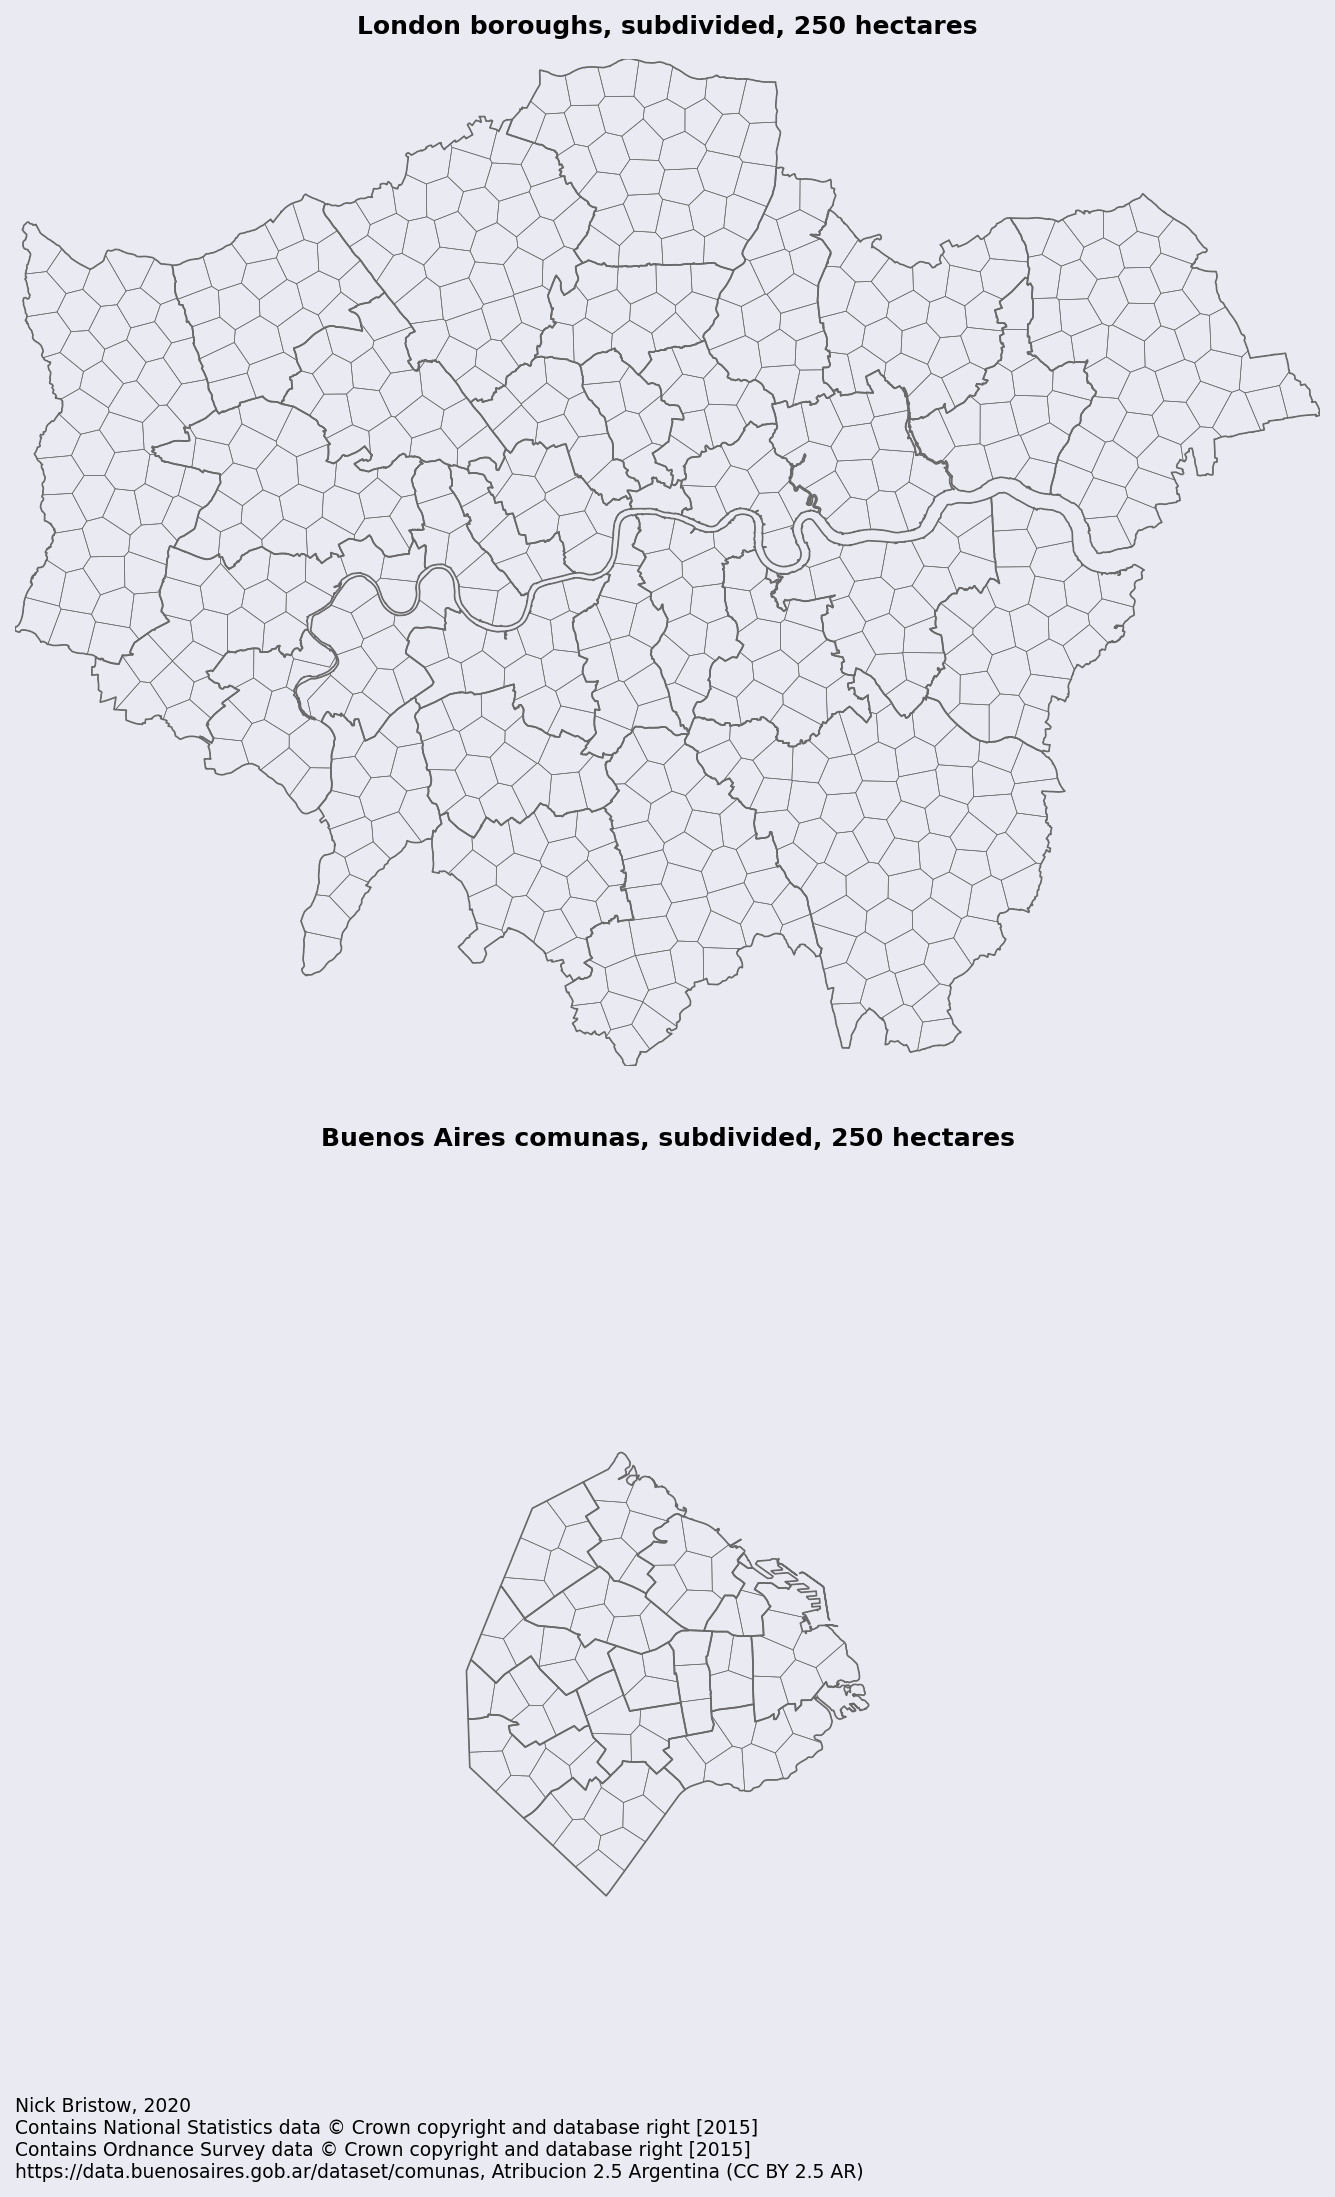

In [115]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,15), dpi=150)
fig.patch.set_facecolor('#EAEAF2')

subdivided_London_boroughs.plot(ax=ax1, facecolor='none', edgecolor='dimgrey', linewidth=0.3)
London_boroughs.plot(ax=ax1, facecolor='none', edgecolor='dimgrey', linewidth=0.8)
ax1.set_xlim(left = gla_centre_x - gla_width/2,
             right = gla_centre_x + gla_width/2)
ax1.set_ylim(bottom = gla_centre_y - gla_height/2,
             top = gla_centre_y + gla_height/2)
ax1.set_title('London boroughs, subdivided, 250 hectares',
              pad=12,
              fontdict={'fontsize': 12,
                        'fontweight': 'bold',
                       })
ax1.axis('off')

subdivided_Buenos_Aires_comunas.plot(ax=ax2, facecolor='none', edgecolor='dimgrey', linewidth=0.3)
Buenos_Aires_comunas.plot(ax=ax2, facecolor='none', edgecolor='dimgrey', linewidth=0.8)
ax2.set_xlim(left = caba_centre_x - gla_width/2,
             right = caba_centre_x + gla_width/2)
ax2.set_ylim(bottom = caba_centre_y - gla_height/2,
             top = caba_centre_y + gla_height/2)
ax2.set_title('Buenos Aires comunas, subdivided, 250 hectares',
              pad=12,
              fontdict={'fontsize': 12,
                        'fontweight': 'bold',
                       })
ax2.axis('off')

# Attribution
ax2.text(5614485, 6146364, "Nick Bristow, 2020\n"
         "Contains National Statistics data © Crown copyright and database right [2015]\n"
         "Contains Ordnance Survey data © Crown copyright and database right [2015]\n"
         "https://data.buenosaires.gob.ar/dataset/comunas, Atribucion 2.5 Argentina (CC BY 2.5 AR)",
         fontdict = {'fontsize':9})

# Save the file
fig.tight_layout()
fig.savefig('London_boroughs_Buenos_Aires_comunas_subdivided.png', facecolor='#EAEAF2')